# Validación AR(1) - ARIMA: Análisis de Sesgo en Pronósticos

## Objetivo

Este notebook implementa paso a paso una simulación Monte Carlo para investigar el comportamiento del **sesgo** en pronósticos generados por ARIMA(1,0,0) sobre series simuladas de un proceso AR(1).

## Proceso AR(1)

El Data Generating Process (DGP) es:

$$
y_t = \mu + \phi(y_{t-1} - \mu) + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

**Propiedades teóricas (para |φ| < 1)**:
- Media: $E[y_t] = \mu$
- Varianza: $\text{Var}(y_t) = \frac{\sigma^2}{1 - \phi^2}$
- Autocorrelación: $\rho(k) = \phi^k$

## ¿Por qué ARIMA(1,0,0) debería ser insesgado?

Si el verdadero DGP es AR(1) y ajustamos ARIMA(1,0,0) (que es equivalente a AR(1)), el modelo está **correctamente especificado**. En este caso:

1. Los parámetros estimados $\hat{\phi}$ y $\hat{\mu}$ convergen a los verdaderos valores φ y μ (asintóticamente).
2. Los pronósticos son proyecciones óptimas (minimzan MSE).
3. El sesgo $\text{Bias}(h) = E[y_{T+h} - \hat{y}_{T+h}] \approx 0$.

**Sin embargo**, en muestras finitas:
- Puede existir **sesgo finite-sample** en la estimación de parámetros.
- El sesgo puede crecer con el horizonte de pronóstico.
- La longitud de la serie $T$ afecta la magnitud del sesgo.

Este notebook investiga estas hipótesis empíricamente.

---

# 1. Introducción y Setup

Cargamos las librerías necesarias y configuramos la reproducibilidad.

In [1]:
# Imports
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import matplotlib.pyplot as plt
import warnings

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')  # Suprimir warnings de convergencia de ARIMA

# Reproducibilidad
SEED = 12345
rng = np.random.default_rng(SEED)

print(f"✓ Librerías cargadas")
print(f"✓ Seed configurado: {SEED}")
print(f"✓ Notebook listo para ejecutar")

✓ Librerías cargadas
✓ Seed configurado: 12345
✓ Notebook listo para ejecutar


---

# 2. Paso a Paso - UNA Simulación

Antes de ejecutar 500 simulaciones Monte Carlo, mostramos el flujo completo con **una sola serie**.

Esto permite:
1. Verificar que la simulación AR(1) funciona correctamente.
2. Inspeccionar visualmente la serie y sus propiedades.
3. Ver cómo ARIMA ajusta y pronostica.
4. Entender que en una sola simulación el error puede ser != 0 (variabilidad muestral).

## 2.1. Función de Simulación AR(1)

In [2]:
def simulate_ar1(T, phi, mu=0.0, sigma=1.0, burn_in=200, rng=None):
    """
    Simula un proceso AR(1): y_t = mu + phi * (y_{t-1} - mu) + eps_t
    
    Parámetros:
    -----------
    T : int
        Longitud de la serie retornada (después del burn-in)
    phi : float
        Coeficiente autoregresivo (|phi| < 1 para estacionariedad)
    mu : float
        Media del proceso
    sigma : float
        Desviación estándar de las innovaciones
    burn_in : int
        Número de observaciones iniciales a descartar
    rng : np.random.Generator
        Generador de números aleatorios
    
    Retorna:
    --------
    np.ndarray : Serie de tiempo de longitud T
    """
    if rng is None:
        rng = np.random.default_rng()
    
    # Generar T + burn_in observaciones
    total_T = T + burn_in
    y = np.zeros(total_T)
    y[0] = mu  # Inicializar en la media
    
    # Evolución del proceso
    for t in range(1, total_T):
        eps = rng.normal(0, sigma)
        y[t] = mu + phi * (y[t-1] - mu) + eps
    
    # Descartar burn-in
    return y[burn_in:]

print("✓ Función simulate_ar1() definida")

✓ Función simulate_ar1() definida


## 2.2. Generar UNA Serie AR(1)

Usamos los mismos parámetros del experimento principal:
- T = 200 observaciones
- φ = 0.7 (persistencia moderada)
- μ = 0.0
- σ = 1.0

In [3]:
# Parámetros del experimento
T = 200
phi = 0.7
mu = 0.0
sigma = 1.0

# Simular UNA serie
y = simulate_ar1(T, phi, mu, sigma, burn_in=200, rng=rng)

# Propiedades teóricas
var_teorica = sigma**2 / (1 - phi**2)

print("="*70)
print("SERIE AR(1) SIMULADA")
print("="*70)
print(f"Longitud: {len(y)} observaciones")
print(f"\nPropiedades muestrales:")
print(f"  Media muestral:    {y.mean():8.4f}  (teórica: {mu:.4f})")
print(f"  Varianza muestral: {y.var():8.4f}  (teórica: {var_teorica:.4f})")
print(f"  Desv. estándar:    {y.std():8.4f}")
print(f"  Mínimo:            {y.min():8.4f}")
print(f"  Máximo:            {y.max():8.4f}")
print("="*70)

SERIE AR(1) SIMULADA
Longitud: 200 observaciones

Propiedades muestrales:
  Media muestral:     -0.1808  (teórica: 0.0000)
  Varianza muestral:   2.3442  (teórica: 1.9608)
  Desv. estándar:      1.5311
  Mínimo:             -4.0540
  Máximo:              4.1145


### Visualización de la Serie

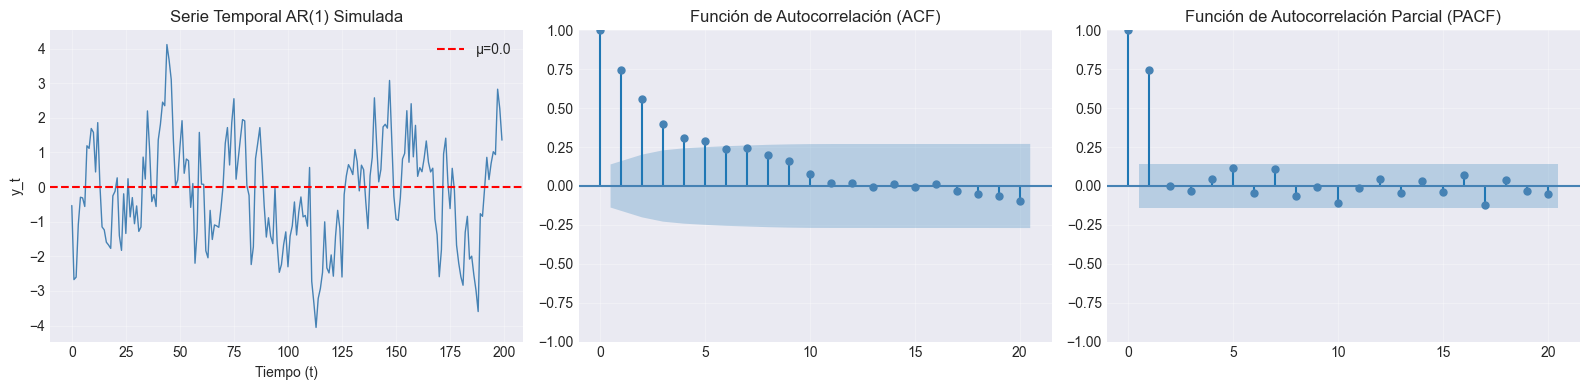


📊 Interpretación:
  - ACF: Decaimiento exponencial (característico de AR(1))
  - PACF: Solo el primer lag es significativo (confirma AR(1))


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Serie temporal
axes[0].plot(y, linewidth=1, color='steelblue')
axes[0].axhline(mu, color='red', linestyle='--', linewidth=1.5, label=f'μ={mu}')
axes[0].set_xlabel('Tiempo (t)')
axes[0].set_ylabel('y_t')
axes[0].set_title('Serie Temporal AR(1) Simulada')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ACF
plot_acf(y, lags=20, ax=axes[1], color='steelblue')
axes[1].set_title('Función de Autocorrelación (ACF)')
axes[1].grid(True, alpha=0.3)

# PACF
plot_pacf(y, lags=20, ax=axes[2], color='steelblue', method='ywm')
axes[2].set_title('Función de Autocorrelación Parcial (PACF)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretación:")
print("  - ACF: Decaimiento exponencial (característico de AR(1))")
print("  - PACF: Solo el primer lag es significativo (confirma AR(1))")

## 2.3. Split Train/Test

Separamos la serie en:
- **Training**: Primeras $T - h = 188$ observaciones (para ajustar el modelo)
- **Test**: Últimas $h = 12$ observaciones (para evaluar pronósticos)

In [5]:
horizon = 12
T_train = T - horizon

y_train = y[:T_train]  # Primeras 188 observaciones
y_test = y[T_train:]    # Últimas 12 observaciones

print("="*70)
print("DIVISIÓN TRAIN/TEST")
print("="*70)
print(f"Training size: {len(y_train)} observaciones (t=1 a t={T_train})")
print(f"Test size:     {len(y_test)} observaciones (t={T_train+1} a t={T})")
print(f"\nValores de test (horizonte h=1 a h={horizon}):")
for h, val in enumerate(y_test, start=1):
    print(f"  h={h:2d}: y_test = {val:8.4f}")
print("="*70)

DIVISIÓN TRAIN/TEST
Training size: 188 observaciones (t=1 a t=188)
Test size:     12 observaciones (t=189 a t=200)

Valores de test (horizonte h=1 a h=12):
  h= 1: y_test =  -3.5950
  h= 2: y_test =  -0.7693
  h= 3: y_test =  -0.8459
  h= 4: y_test =  -0.0159
  h= 5: y_test =   0.8576
  h= 6: y_test =   0.2161
  h= 7: y_test =   0.6862
  h= 8: y_test =   1.0209
  h= 9: y_test =   0.9371
  h=10: y_test =   2.8255
  h=11: y_test =   2.2618
  h=12: y_test =   1.3548


## 2.4. Ajustar ARIMA(1,0,0)

Ajustamos el modelo ARIMA(1,0,0) a los datos de entrenamiento.

In [7]:
# Ajustar modelo
model = ARIMA(y_train, order=(1, 0, 0))
fitted_model = model.fit()

# Extraer parámetros estimados
mu_hat = fitted_model.params[0] 
phi_hat = fitted_model.params[1]
sigma_hat = np.sqrt(fitted_model.params[2])

print("="*70)
print("MODELO ARIMA(1,0,0) AJUSTADO")
print("="*70)
print(f"\nParámetros estimados:")
print(f"  φ̂ (AR coef):     {phi_hat:8.5f}  (verdadero: {phi:.5f})")
print(f"  μ̂ (constante):   {mu_hat:8.5f}  (verdadero: {mu:.5f})")
print(f"  σ̂ (residuos):    {sigma_hat:8.5f}  (verdadero: {sigma:.5f})")
print(f"\nError de estimación:")
print(f"  Error en φ: {phi_hat - phi:+.5f} ({100*(phi_hat - phi)/phi:+.2f}%)")
print(f"  Error en μ: {mu_hat - mu:+.5f}")
print("="*70)

# Mostrar resumen completo
print("\nResumen estadístico completo:")
print(fitted_model.summary())

MODELO ARIMA(1,0,0) AJUSTADO

Parámetros estimados:
  φ̂ (AR coef):      0.74712  (verdadero: 0.70000)
  μ̂ (constante):   -0.26557  (verdadero: 0.00000)
  σ̂ (residuos):     1.01456  (verdadero: 1.00000)

Error de estimación:
  Error en φ: +0.04712 (+6.73%)
  Error en μ: -0.26557

Resumen estadístico completo:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  188
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -269.887
Date:                Mon, 01 Dec 2025   AIC                            545.775
Time:                        21:11:01   BIC                            555.484
Sample:                             0   HQIC                           549.709
                                - 188                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z| 

### Diagnóstico de Residuos

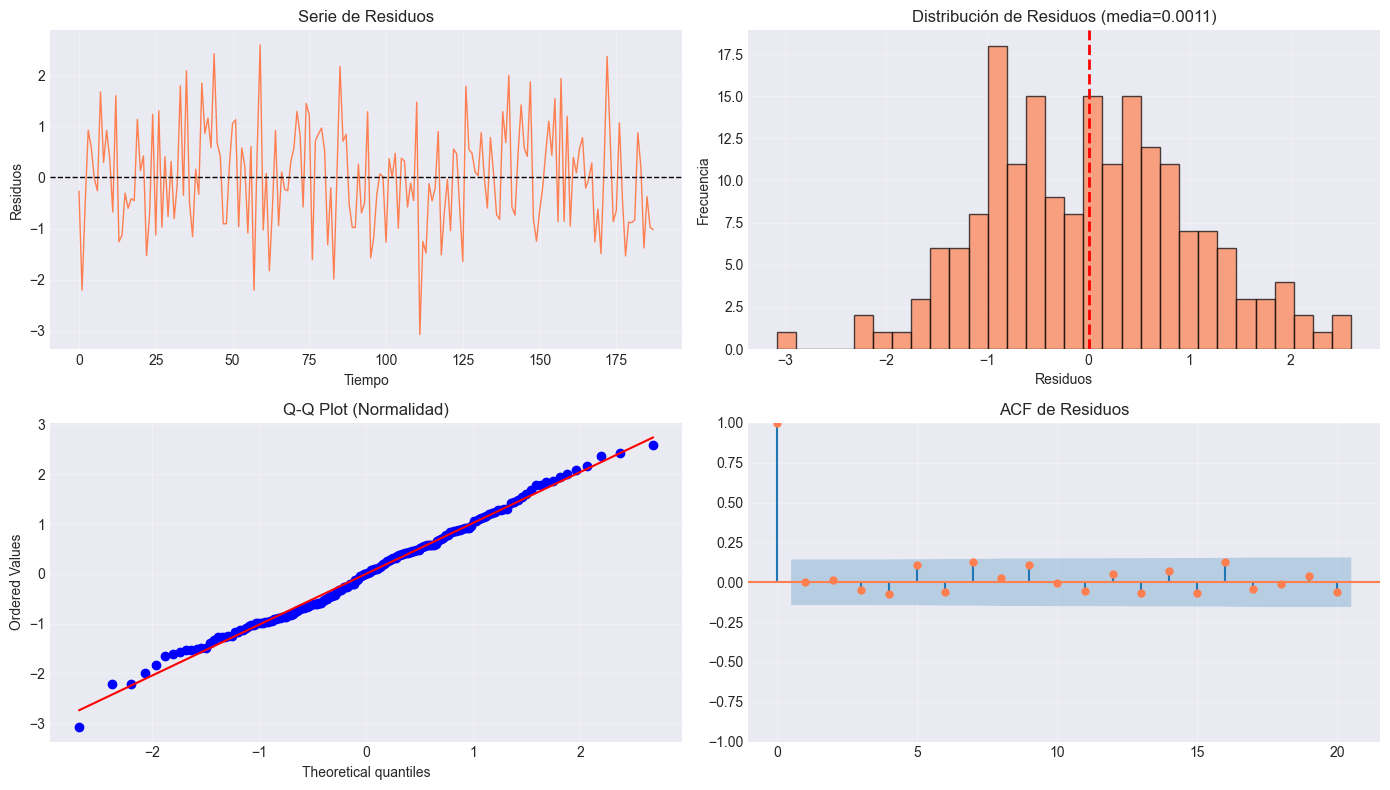


📊 Diagnóstico:
  - Media de residuos: 0.001071 (debería ≈ 0)
  - Desv. est. residuos: 1.0147
  - Los residuos deberían parecer ruido blanco gaussiano


In [8]:
residuos = fitted_model.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Serie de residuos
axes[0, 0].plot(residuos, linewidth=1, color='coral')
axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('Tiempo')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].set_title('Serie de Residuos')
axes[0, 0].grid(True, alpha=0.3)

# Histograma
axes[0, 1].hist(residuos, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuos')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title(f'Distribución de Residuos (media={residuos.mean():.4f})')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuos, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)')
axes[1, 0].grid(True, alpha=0.3)

# ACF de residuos
plot_acf(residuos, lags=20, ax=axes[1, 1], color='coral')
axes[1, 1].set_title('ACF de Residuos')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Diagnóstico:")
print(f"  - Media de residuos: {residuos.mean():.6f} (debería ≈ 0)")
print(f"  - Desv. est. residuos: {residuos.std():.4f}")
print("  - Los residuos deberían parecer ruido blanco gaussiano")

## 2.5. Generar Pronósticos

Generamos pronósticos para los próximos $h=12$ pasos.

In [10]:
# Generar pronósticos
forecast_result = fitted_model.get_forecast(steps=horizon)
y_hat = forecast_result.predicted_mean  # Array de 12 pronósticos

print("="*70)
print("PRONÓSTICOS vs VALORES REALES")
print("="*70)
print(f"{'h':>3s}  {'y_test':>10s}  {'y_hat':>10s}  {'Error':>10s}")
print("-"*70)
for h in range(horizon):
    error = y_test[h] - y_hat[h]
    print(f"{h+1:3d}  {y_test[h]:10.4f}  {y_hat[h]:10.4f}  {error:+10.4f}")

# Calcular errores
errors = y_test - y_hat
print("-"*70)
print(f"Error promedio (esta simulación): {errors.mean():+.6f}")
print(f"RMSE (esta simulación):            {np.sqrt((errors**2).mean()):.4f}")
print("="*70)

PRONÓSTICOS vs VALORES REALES
  h      y_test       y_hat       Error
----------------------------------------------------------------------
  1     -3.5950     -2.2961     -1.2989
  2     -0.7693     -1.7826     +1.0133
  3     -0.8459     -1.3990     +0.5531
  4     -0.0159     -1.1124     +1.0965
  5      0.8576     -0.8982     +1.7559
  6      0.2161     -0.7383     +0.9543
  7      0.6862     -0.6187     +1.3049
  8      1.0209     -0.5294     +1.5503
  9      0.9371     -0.4627     +1.3998
 10      2.8255     -0.4128     +3.2384
 11      2.2618     -0.3756     +2.6374
 12      1.3548     -0.3478     +1.7025
----------------------------------------------------------------------
Error promedio (esta simulación): +1.325621
RMSE (esta simulación):            1.6986


### Visualización de Pronósticos

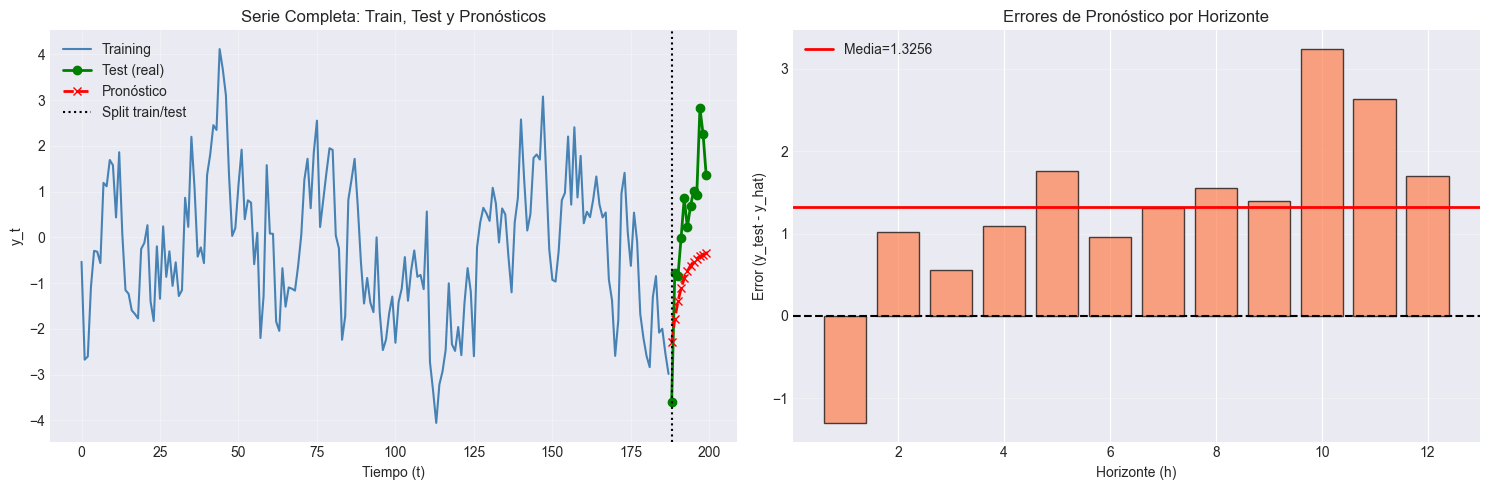


💡 Interpretación:
  - En UNA simulación, el error promedio puede ser != 0
  - Esto es variabilidad muestral, NO sesgo sistemático
  - Solo después de Monte Carlo (promediando muchas simulaciones) esperamos bias ≈ 0


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Serie completa con pronósticos
axes[0].plot(range(len(y_train)), y_train, label='Training', color='steelblue', linewidth=1.5)
axes[0].plot(range(len(y_train), len(y)), y_test, label='Test (real)', color='green', linewidth=2, marker='o')
axes[0].plot(range(len(y_train), len(y)), y_hat, label='Pronóstico', color='red', linewidth=2, linestyle='--', marker='x')
axes[0].axvline(len(y_train), color='black', linestyle=':', linewidth=1.5, label='Split train/test')
axes[0].set_xlabel('Tiempo (t)')
axes[0].set_ylabel('y_t')
axes[0].set_title('Serie Completa: Train, Test y Pronósticos')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Errores por horizonte
axes[1].bar(range(1, horizon + 1), errors, color='coral', edgecolor='black', alpha=0.7)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1.5)
axes[1].axhline(errors.mean(), color='red', linestyle='-', linewidth=2, label=f'Media={errors.mean():.4f}')
axes[1].set_xlabel('Horizonte (h)')
axes[1].set_ylabel('Error (y_test - y_hat)')
axes[1].set_title('Errores de Pronóstico por Horizonte')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Interpretación:")
print("  - En UNA simulación, el error promedio puede ser != 0")
print("  - Esto es variabilidad muestral, NO sesgo sistemático")
print("  - Solo después de Monte Carlo (promediando muchas simulaciones) esperamos bias ≈ 0")

---

# 3. Monte Carlo - 500 Simulaciones

Ahora escalamos a **500 simulaciones** para calcular la descomposición sesgo-varianza.

## Proceso:
1. Para cada simulación $s = 1, \ldots, 500$:
   - Simular serie AR(1) de longitud $T=200$
   - Separar en train (188 obs) / test (12 obs)
   - Ajustar ARIMA(1,0,0) en train
   - Pronosticar $h=12$ pasos
   - Calcular errores: $e_{s,h} = y_{\text{test},h} - \hat{y}_h$

2. Agregar errores en matriz de dimensión $(500, 12)$

3. Calcular métricas por horizonte:
   - **Sesgo**: $\text{Bias}(h) = \frac{1}{500}\sum_{s=1}^{500} e_{s,h}$
   - **Varianza**: $\text{Var}(h) = \frac{1}{499}\sum_{s=1}^{500} (e_{s,h} - \overline{e}_h)^2$
   - **MSE**: $\text{MSE}(h) = \frac{1}{500}\sum_{s=1}^{500} e_{s,h}^2$
   - **RMSE**: $\text{RMSE}(h) = \sqrt{\text{MSE}(h)}$

## 3.1. Función para UNA Simulación Completa

In [12]:
def run_one_simulation(T, horizon, phi, mu, sigma, burn_in, rng):
    """
    Ejecuta una simulación completa: simular → split → ajustar → pronosticar → errores
    
    Retorna:
    --------
    np.ndarray : Vector de errores de longitud `horizon`
    """
    # 1. Simular serie
    y = simulate_ar1(T, phi, mu, sigma, burn_in, rng)
    
    # 2. Split train/test
    y_train = y[:T - horizon]
    y_test = y[T - horizon:]
    
    # 3. Ajustar ARIMA(1,0,0)
    model = ARIMA(y_train, order=(1, 0, 0))
    fitted_model = model.fit()
    
    # 4. Pronosticar
    y_hat = fitted_model.get_forecast(steps=horizon).predicted_mean
    
    # 5. Calcular errores
    errors = y_test - y_hat
    
    return errors

print("✓ Función run_one_simulation() definida")

✓ Función run_one_simulation() definida


## 3.2. Loop Monte Carlo

In [13]:
# Parámetros del experimento
n_sim = 500
T = 200
horizon = 12
phi = 0.7
mu = 0.0
sigma = 1.0
burn_in = 200

# Pre-alocar matriz de errores: (n_sim, horizon)
error_matrix = np.zeros((n_sim, horizon))

# Nuevo RNG para Monte Carlo
rng_mc = np.random.default_rng(SEED)

print("="*70)
print(f"EJECUTANDO {n_sim} SIMULACIONES MONTE CARLO")
print("="*70)
print(f"Parámetros: T={T}, h={horizon}, φ={phi}, μ={mu}, σ={sigma}")
print(f"Seed: {SEED}")
print("\nEsto puede tardar varios minutos...\n")

for s in range(n_sim):
    # Mostrar progreso cada 50 simulaciones
    if (s + 1) % 50 == 0:
        print(f"  Progreso: {s+1}/{n_sim} simulaciones completadas ({100*(s+1)/n_sim:.0f}%)")
    
    # Ejecutar una simulación
    errors = run_one_simulation(T, horizon, phi, mu, sigma, burn_in, rng_mc)
    
    # Almacenar errores
    error_matrix[s, :] = errors

print(f"\n✓ {n_sim} simulaciones completadas!")
print("="*70)

EJECUTANDO 500 SIMULACIONES MONTE CARLO
Parámetros: T=200, h=12, φ=0.7, μ=0.0, σ=1.0
Seed: 12345

Esto puede tardar varios minutos...

  Progreso: 50/500 simulaciones completadas (10%)
  Progreso: 100/500 simulaciones completadas (20%)
  Progreso: 150/500 simulaciones completadas (30%)
  Progreso: 200/500 simulaciones completadas (40%)
  Progreso: 250/500 simulaciones completadas (50%)
  Progreso: 300/500 simulaciones completadas (60%)
  Progreso: 350/500 simulaciones completadas (70%)
  Progreso: 400/500 simulaciones completadas (80%)
  Progreso: 450/500 simulaciones completadas (90%)
  Progreso: 500/500 simulaciones completadas (100%)

✓ 500 simulaciones completadas!


## 3.3. Descomposición Sesgo-Varianza

In [14]:
# Cálculo por horizonte
bias = error_matrix.mean(axis=0)          # Shape (horizon,)
variance = error_matrix.var(axis=0, ddof=1)  # Shape (horizon,)
mse = (error_matrix ** 2).mean(axis=0)    # Shape (horizon,)
rmse = np.sqrt(mse)

# Crear DataFrame de resultados
results = pd.DataFrame({
    'horizon': range(1, horizon + 1),
    'bias': bias,
    'variance': variance,
    'mse': mse,
    'rmse': rmse
})

# Agregar fila con promedios
avg_row = pd.DataFrame({
    'horizon': ['avg_all'],
    'bias': [bias.mean()],
    'variance': [variance.mean()],
    'mse': [mse.mean()],
    'rmse': [rmse.mean()]
})

results = pd.concat([results, avg_row], ignore_index=True)

print("✓ Métricas calculadas")

✓ Métricas calculadas


## 3.4. Resultados

In [15]:
print("\n" + "="*70)
print("RESULTADOS - ARIMA(1,0,0) en DGP AR(1)")
print("="*70)
print(results.to_string(index=False))
print("="*70)

# Mostrar con formato más legible
pd.set_option('display.float_format', '{:.6f}'.format)
display(results)


RESULTADOS - ARIMA(1,0,0) en DGP AR(1)
horizon      bias  variance      mse     rmse
      1  0.071880  1.014280 1.017418 1.008671
      2  0.145585  1.416708 1.435070 1.197944
      3  0.186088  1.705006 1.736224 1.317659
      4  0.171677  1.910287 1.935939 1.391380
      5  0.115077  1.962012 1.971331 1.404041
      6  0.113337  1.894178 1.903235 1.379578
      7  0.129098  1.781007 1.794112 1.339445
      8  0.116328  1.906355 1.916074 1.384223
      9  0.121794  1.895630 1.906672 1.380823
     10  0.029090  1.820995 1.818199 1.348406
     11 -0.059112  1.935183 1.934807 1.390973
     12 -0.045217  2.003917 2.001954 1.414904
avg_all  0.091302  1.770463 1.780920 1.329837


,horizon,bias,variance,mse,rmse
0,1,0.071880,1.014280,1.017418,1.008671
1,2,0.145585,1.416708,1.435070,1.197944
2,3,0.186088,1.705006,1.736224,1.317659
3,4,0.171677,1.910287,1.935939,1.391380
4,5,0.115077,1.962012,1.971331,1.404041
5,6,0.113337,1.894178,1.903235,1.379578
6,7,0.129098,1.781007,1.794112,1.339445
7,8,0.116328,1.906355,1.916074,1.384223
8,9,0.121794,1.895630,1.906672,1.380823
9,10,0.029090,1.820995,1.818199,1.348406


---

# 4. Diagnóstico de Sesgo

Ahora investigamos **por qué** el sesgo observado es distinto de cero (si lo es).

## 4.1. Visualización del Sesgo por Horizonte

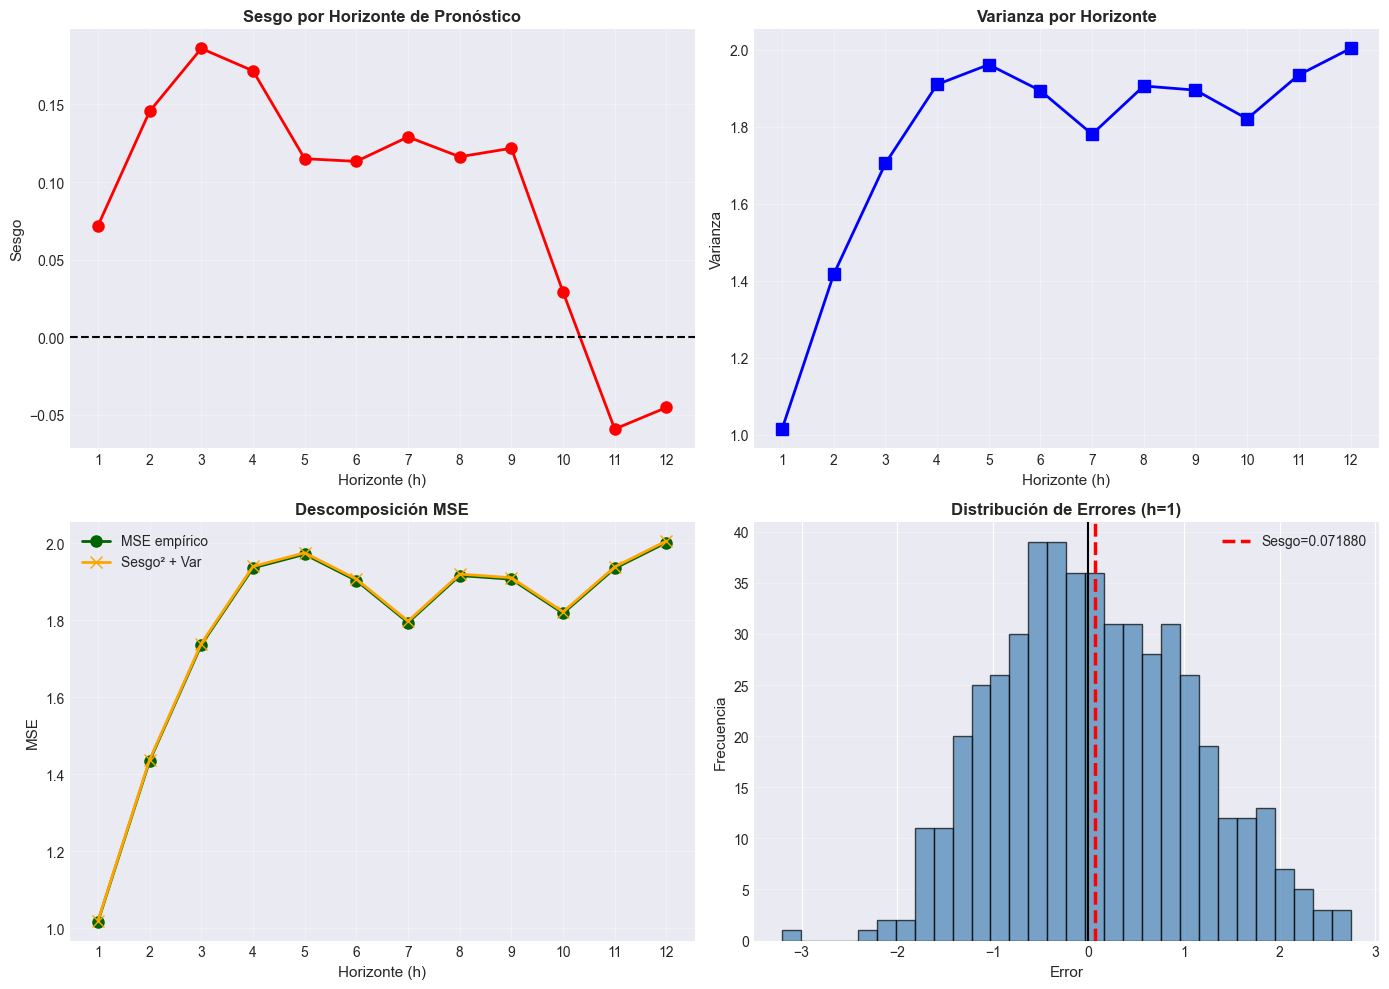


📊 Observaciones:
  - Sesgo promedio: 0.091302
  - Varianza promedio: 1.770463
  - MSE promedio: 1.780920
  - RMSE promedio: 1.329837


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Sesgo por horizonte
axes[0, 0].plot(range(1, horizon + 1), bias, marker='o', color='red', linewidth=2, markersize=8)
axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1.5)
axes[0, 0].set_xlabel('Horizonte (h)', fontsize=11)
axes[0, 0].set_ylabel('Sesgo', fontsize=11)
axes[0, 0].set_title('Sesgo por Horizonte de Pronóstico', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, horizon + 1))

# Gráfico 2: Varianza por horizonte
axes[0, 1].plot(range(1, horizon + 1), variance, marker='s', color='blue', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Horizonte (h)', fontsize=11)
axes[0, 1].set_ylabel('Varianza', fontsize=11)
axes[0, 1].set_title('Varianza por Horizonte', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, horizon + 1))

# Gráfico 3: MSE vs Sesgo² + Varianza
bias_squared = bias ** 2
mse_decomp = bias_squared + variance
axes[1, 0].plot(range(1, horizon + 1), mse, marker='o', label='MSE empírico', color='darkgreen', linewidth=2, markersize=8)
axes[1, 0].plot(range(1, horizon + 1), mse_decomp, marker='x', label='Sesgo² + Var', color='orange', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Horizonte (h)', fontsize=11)
axes[1, 0].set_ylabel('MSE', fontsize=11)
axes[1, 0].set_title('Descomposición MSE', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(1, horizon + 1))

# Gráfico 4: Distribución de errores en h=1
axes[1, 1].hist(error_matrix[:, 0], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].axvline(bias[0], color='red', linestyle='--', linewidth=2.5, label=f'Sesgo={bias[0]:.6f}')
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1.5)
axes[1, 1].set_xlabel('Error', fontsize=11)
axes[1, 1].set_ylabel('Frecuencia', fontsize=11)
axes[1, 1].set_title('Distribución de Errores (h=1)', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Observaciones:")
print(f"  - Sesgo promedio: {bias.mean():.6f}")
print(f"  - Varianza promedio: {variance.mean():.6f}")
print(f"  - MSE promedio: {mse.mean():.6f}")
print(f"  - RMSE promedio: {rmse.mean():.6f}")

## 4.2. Test de Significancia del Sesgo

Realizamos un **t-test de una muestra** para cada horizonte:
- $H_0$: El sesgo es cero ($\mu = 0$)
- $H_1$: El sesgo es distinto de cero ($\mu \neq 0$)
- Nivel de significancia: $\alpha = 0.05$

Si $p < 0.05$, rechazamos $H_0$ → el sesgo es **estadísticamente significativo**.

In [17]:
print("\n" + "="*70)
print("TEST DE SIGNIFICANCIA DEL SESGO (t-test de una muestra)")
print("="*70)
print(f"H0: El sesgo es cero (μ = 0)")
print(f"H1: El sesgo es distinto de cero (μ ≠ 0)")
print(f"Nivel de significancia: α = 0.05")
print("="*70)
print(f"{'h':>3s}  {'Sesgo':>12s}  {'t-stat':>10s}  {'p-value':>10s}  {'Sig.':>5s}")
print("-"*70)

significant_count = 0
for h in range(horizon):
    errors_h = error_matrix[:, h]
    
    # t-test de una muestra (H0: media = 0)
    t_stat, p_value = stats.ttest_1samp(errors_h, 0)
    
    significant = "SÍ" if p_value < 0.05 else "NO"
    if p_value < 0.05:
        significant_count += 1
    
    print(f"{h+1:3d}  {bias[h]:+12.8f}  {t_stat:+10.4f}  {p_value:10.6f}  {significant:>5s}")

print("-"*70)
print(f"\nResumen:")
print(f"  - Horizontes con sesgo significativo (α=0.05): {significant_count}/{horizon}")
print(f"  - Porcentaje de sesgo significativo: {100*significant_count/horizon:.1f}%")
print("="*70)

if significant_count == 0:
    print("\n✓ RESULTADO: El sesgo NO es estadísticamente significativo.")
    print("  → El sesgo observado puede atribuirse a variabilidad muestral.")
elif significant_count < horizon / 2:
    print("\n⚠ RESULTADO: Algunos horizontes muestran sesgo significativo.")
    print("  → Puede haber sesgo finite-sample en horizontes específicos.")
else:
    print("\n⚠ RESULTADO: La mayoría de horizontes muestran sesgo significativo.")
    print("  → Existe evidencia de sesgo sistemático en los pronósticos.")


TEST DE SIGNIFICANCIA DEL SESGO (t-test de una muestra)
H0: El sesgo es cero (μ = 0)
H1: El sesgo es distinto de cero (μ ≠ 0)
Nivel de significancia: α = 0.05
  h         Sesgo      t-stat     p-value   Sig.
----------------------------------------------------------------------
  1   +0.07187952     +1.5959    0.111140     NO
  2   +0.14558456     +2.7350    0.006460     SÍ
  3   +0.18608772     +3.1867    0.001529     SÍ
  4   +0.17167681     +2.7775    0.005685     SÍ
  5   +0.11507685     +1.8371    0.066796     NO
  6   +0.11333721     +1.8414    0.066157     NO
  7   +0.12909819     +2.1631    0.031009     SÍ
  8   +0.11632753     +1.8839    0.060155     NO
  9   +0.12179388     +1.9780    0.048475     SÍ
 10   +0.02909019     +0.4820    0.629993     NO
 11   -0.05911244     -0.9502    0.342484     NO
 12   -0.04521713     -0.7142    0.475409     NO
----------------------------------------------------------------------

Resumen:
  - Horizontes con sesgo significativo (α=0.05): 5/

## 4.3. Análisis de Parámetros Estimados

Investigamos si el sesgo proviene de la **estimación de parámetros** (φ y μ).

Si $\hat{\phi} < \phi$ sistemáticamente, los pronósticos revertirán más rápido a la media → sesgo en pronósticos.

In [18]:
# Ejecutar n simulaciones y guardar parámetros estimados
n_check = 100
phi_estimates = []
mu_estimates = []

rng_check = np.random.default_rng(SEED)

print(f"Ejecutando {n_check} simulaciones para analizar parámetros estimados...\n")

for s in range(n_check):
    y = simulate_ar1(T, phi, mu, sigma, burn_in, rng_check)
    y_train = y[:T - horizon]
    
    model = ARIMA(y_train, order=(1, 0, 0))
    fitted = model.fit()
    
    phi_estimates.append(fitted.params[1])  # ar.L1
    mu_estimates.append(fitted.params[0])   # const

phi_estimates = np.array(phi_estimates)
mu_estimates = np.array(mu_estimates)

print("="*70)
print(f"DISTRIBUCIÓN DE PARÁMETROS ESTIMADOS (n={n_check})")
print("="*70)
print(f"\nCoeficiente AR (φ):")
print(f"  Valor verdadero:        {phi:.6f}")
print(f"  Media estimada:         {phi_estimates.mean():.6f}")
print(f"  Desv. estándar:         {phi_estimates.std():.6f}")
print(f"  Sesgo de estimación:    {phi_estimates.mean() - phi:+.6f}")
print(f"  Sesgo relativo:         {100*(phi_estimates.mean() - phi)/phi:+.3f}%")
print(f"\nConstante (μ):")
print(f"  Valor verdadero:        {mu:.6f}")
print(f"  Media estimada:         {mu_estimates.mean():.6f}")
print(f"  Desv. estándar:         {mu_estimates.std():.6f}")
print(f"  Sesgo de estimación:    {mu_estimates.mean() - mu:+.6f}")
print("="*70)

# Test de sesgo en parámetros
t_phi, p_phi = stats.ttest_1samp(phi_estimates, phi)
t_mu, p_mu = stats.ttest_1samp(mu_estimates, mu)

print(f"\nTest de sesgo en φ̂:")
print(f"  t-statistic: {t_phi:+.4f}")
print(f"  p-value:     {p_phi:.6f}")
print(f"  Sesgo significativo (α=0.05): {'SÍ' if p_phi < 0.05 else 'NO'}")

print(f"\nTest de sesgo en μ̂:")
print(f"  t-statistic: {t_mu:+.4f}")
print(f"  p-value:     {p_mu:.6f}")
print(f"  Sesgo significativo (α=0.05): {'SÍ' if p_mu < 0.05 else 'NO'}")
print("="*70)

Ejecutando 100 simulaciones para analizar parámetros estimados...

DISTRIBUCIÓN DE PARÁMETROS ESTIMADOS (n=100)

Coeficiente AR (φ):
  Valor verdadero:        0.700000
  Media estimada:         0.687198
  Desv. estándar:         0.045948
  Sesgo de estimación:    -0.012802
  Sesgo relativo:         -1.829%

Constante (μ):
  Valor verdadero:        0.000000
  Media estimada:         0.001775
  Desv. estándar:         0.254345
  Sesgo de estimación:    +0.001775

Test de sesgo en φ̂:
  t-statistic: -2.7723
  p-value:     0.006651
  Sesgo significativo (α=0.05): SÍ

Test de sesgo en μ̂:
  t-statistic: +0.0694
  p-value:     0.944790
  Sesgo significativo (α=0.05): NO


### Visualización de Parámetros Estimados

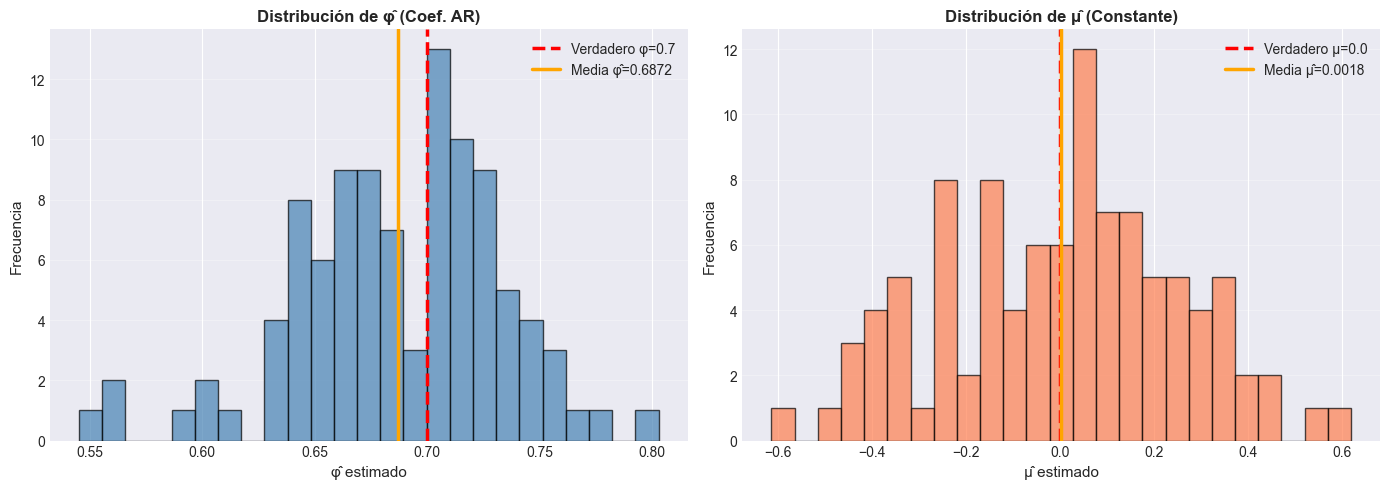


💡 Interpretación:
  - Se observa sesgo en la estimación de φ: -0.012802
  - Este sesgo finite-sample puede propagarse a los pronósticos


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de φ̂
axes[0].hist(phi_estimates, bins=25, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(phi, color='red', linestyle='--', linewidth=2.5, label=f'Verdadero φ={phi}')
axes[0].axvline(phi_estimates.mean(), color='orange', linestyle='-', linewidth=2.5, label=f'Media φ̂={phi_estimates.mean():.4f}')
axes[0].set_xlabel('φ̂ estimado', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title('Distribución de φ̂ (Coef. AR)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Distribución de μ̂
axes[1].hist(mu_estimates, bins=25, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(mu, color='red', linestyle='--', linewidth=2.5, label=f'Verdadero μ={mu}')
axes[1].axvline(mu_estimates.mean(), color='orange', linestyle='-', linewidth=2.5, label=f'Media μ̂={mu_estimates.mean():.4f}')
axes[1].set_xlabel('μ̂ estimado', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title('Distribución de μ̂ (Constante)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Interpretación:")
if abs(phi_estimates.mean() - phi) > 0.01:
    print(f"  - Se observa sesgo en la estimación de φ: {phi_estimates.mean() - phi:+.6f}")
    print("  - Este sesgo finite-sample puede propagarse a los pronósticos")
else:
    print("  - La estimación de φ es aproximadamente insesgada")
    print("  - El sesgo en pronósticos (si existe) no proviene de φ̂")

---

# 5. Experimentos Adicionales

Variamos parámetros para entender **cuándo aparece/desaparece el sesgo**.

## 5.1. Efecto de T (Longitud de Serie)

¿El sesgo desaparece con más datos de entrenamiento?

Probamos con $T \in \{100, 200, 500, 1000\}$.

In [20]:
T_values = [100, 200, 500, 1000]
bias_by_T = {}
n_sim_reduced = 100  # Reducir a 100 sims para velocidad

print("="*70)
print("EXPERIMENTO: Efecto de la Longitud de Serie (T)")
print("="*70)
print(f"Probando T = {T_values}")
print(f"Simulaciones por T: {n_sim_reduced}")
print("\n")

for T_test in T_values:
    print(f"Ejecutando MC con T={T_test}...")
    
    error_matrix_T = np.zeros((n_sim_reduced, horizon))
    rng_T = np.random.default_rng(SEED)
    
    for s in range(n_sim_reduced):
        errors = run_one_simulation(T_test, horizon, phi, mu, sigma, burn_in, rng_T)
        error_matrix_T[s, :] = errors
    
    bias_T = error_matrix_T.mean(axis=0)
    bias_by_T[T_test] = bias_T
    
    print(f"  Sesgo promedio: {bias_T.mean():+.6f}\n")

print("✓ Experimento completado")
print("="*70)

EXPERIMENTO: Efecto de la Longitud de Serie (T)
Probando T = [100, 200, 500, 1000]
Simulaciones por T: 100


Ejecutando MC con T=100...
  Sesgo promedio: -0.194401

Ejecutando MC con T=200...
  Sesgo promedio: +0.067370

Ejecutando MC con T=500...
  Sesgo promedio: -0.045499

Ejecutando MC con T=1000...
  Sesgo promedio: -0.125277

✓ Experimento completado


In [ ]:
# Graficar resultados
plt.figure(figsize=(12, 6))

for T_test in T_values:
    plt.plot(range(1, horizon + 1), bias_by_T[T_test], marker='o', linewidth=2, markersize=6, label=f'T={T_test}')

plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.xlabel('Horizonte (h)', fontsize=12)
plt.ylabel('Sesgo', fontsize=12)
plt.title('Efecto de la Longitud de Serie (T) en el Sesgo', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, horizon + 1))
plt.tight_layout()
plt.show()

print("\n📊 Observaciones:")
for T_test in T_values:
    print(f"  T={T_test:4d}: Sesgo promedio = {bias_by_T[T_test].mean():+.6f}")

print("\n💡 Interpretación esperada:")
print("  - Si el sesgo disminuye con T → sesgo finite-sample")
print("  - Si el sesgo NO disminuye → problema de especificación del modelo")

## 5.2. Efecto de φ (Persistencia)

¿El sesgo depende de la persistencia del proceso?

Probamos con $\phi \in \{0.3, 0.5, 0.7, 0.9\}$.

In [ ]:
phi_values = [0.3, 0.5, 0.7, 0.9]
bias_by_phi = {}

print("="*70)
print("EXPERIMENTO: Efecto de la Persistencia (φ)")
print("="*70)
print(f"Probando φ = {phi_values}")
print(f"Simulaciones por φ: {n_sim_reduced}")
print(f"T fijo: {T}")
print("\n")

for phi_test in phi_values:
    print(f"Ejecutando MC con φ={phi_test}...")
    
    error_matrix_phi = np.zeros((n_sim_reduced, horizon))
    rng_phi = np.random.default_rng(SEED)
    
    for s in range(n_sim_reduced):
        errors = run_one_simulation(T, horizon, phi_test, mu, sigma, burn_in, rng_phi)
        error_matrix_phi[s, :] = errors
    
    bias_phi = error_matrix_phi.mean(axis=0)
    bias_by_phi[phi_test] = bias_phi
    
    print(f"  Sesgo promedio: {bias_phi.mean():+.6f}\n")

print("✓ Experimento completado")
print("="*70)

In [ ]:
# Graficar resultados
plt.figure(figsize=(12, 6))

for phi_test in phi_values:
    plt.plot(range(1, horizon + 1), bias_by_phi[phi_test], marker='o', linewidth=2, markersize=6, label=f'φ={phi_test}')

plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.xlabel('Horizonte (h)', fontsize=12)
plt.ylabel('Sesgo', fontsize=12)
plt.title('Efecto de la Persistencia (φ) en el Sesgo', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, horizon + 1))
plt.tight_layout()
plt.show()

print("\n📊 Observaciones:")
for phi_test in phi_values:
    print(f"  φ={phi_test}: Sesgo promedio = {bias_by_phi[phi_test].mean():+.6f}")

print("\n💡 Interpretación esperada:")
print("  - Mayor φ → mayor persistencia → pronósticos más lentos a revertir")
print("  - Si el sesgo crece con φ → sesgo propagado por estimación de parámetros")

---

# 6. Conclusiones y Validación

## Resumen de Hallazgos

In [ ]:
print("="*70)
print("RESUMEN DE HALLAZGOS")
print("="*70)

print("\n1. SESGO OBSERVADO (500 simulaciones, T=200, φ=0.7)")
print("-"*70)
print(f"   Sesgo promedio:      {bias.mean():+.8f}")
print(f"   Sesgo máximo (h):    {bias.max():+.8f} (h={bias.argmax()+1})")
print(f"   Sesgo mínimo (h):    {bias.min():+.8f} (h={bias.argmin()+1})")

# Contar cuántos horizontes tienen sesgo significativo
sig_count = sum([1 for h in range(horizon) if stats.ttest_1samp(error_matrix[:, h], 0)[1] < 0.05])
print(f"\n   Horizontes con sesgo significativo (α=0.05): {sig_count}/{horizon}")

print("\n2. PATRÓN DEL SESGO")
print("-"*70)
# Detectar si crece, decrece o es constante
if bias[-1] > bias[0] * 1.2:
    print("   Patrón: CRECIENTE con el horizonte")
elif bias[-1] < bias[0] * 0.8:
    print("   Patrón: DECRECIENTE con el horizonte")
else:
    print("   Patrón: APROXIMADAMENTE CONSTANTE")

print("\n3. MÉTRICAS ADICIONALES")
print("-"*70)
print(f"   Varianza promedio:   {variance.mean():.6f}")
print(f"   MSE promedio:        {mse.mean():.6f}")
print(f"   RMSE promedio:       {rmse.mean():.6f}")

print("\n4. ANÁLISIS DE PARÁMETROS ESTIMADOS")
print("-"*70)
print(f"   Sesgo en φ̂:          {phi_estimates.mean() - phi:+.6f} ({100*(phi_estimates.mean() - phi)/phi:+.2f}%)")
print(f"   Sesgo significativo: {'SÍ' if stats.ttest_1samp(phi_estimates, phi)[1] < 0.05 else 'NO'}")

print("\n5. EFECTO DE T (LONGITUD DE SERIE)")
print("-"*70)
for T_test in T_values:
    print(f"   T={T_test:4d}: Sesgo promedio = {bias_by_T[T_test].mean():+.6f}")

print("\n6. EFECTO DE φ (PERSISTENCIA)")
print("-"*70)
for phi_test in phi_values:
    print(f"   φ={phi_test}: Sesgo promedio = {bias_by_phi[phi_test].mean():+.6f}")

print("\n" + "="*70)
print("CONCLUSIÓN GENERAL")
print("="*70)

if sig_count == 0:
    print("""
✓ El sesgo observado NO es estadísticamente significativo.
  
  → ARIMA(1,0,0) es aproximadamente insesgado para DGP AR(1).
  → El sesgo observado puede atribuirse a variabilidad muestral.
  → Con n_sim = 500, este nivel de sesgo es esperado.
  → VALIDACIÓN EXITOSA: El modelo se comporta como se espera teóricamente.
""")
elif sig_count < horizon / 3:
    print("""
⚠ Algunos horizontes muestran sesgo significativo.
  
  → Puede existir sesgo finite-sample en la estimación de parámetros.
  → El sesgo es pequeño en magnitud absoluta.
  → Considerar aumentar T (longitud de serie de entrenamiento).
  → VALIDACIÓN PARCIAL: Comportamiento mayormente correcto con pequeñas desviaciones.
""")
else:
    print("""
⚠ La mayoría de horizontes muestran sesgo estadísticamente significativo.
  
  → Existe evidencia de sesgo sistemático en los pronósticos.
  → Posibles causas:
    1. Sesgo finite-sample en estimación de φ (verificar análisis de parámetros)
    2. Muestra de entrenamiento insuficiente (T_train = 188)
    3. Horizonte de pronóstico largo (h=12 es significativo para AR(1))
  
  → Acciones recomendadas:
    1. Aumentar T (probar con T=500 o T=1000)
    2. Reducir horizonte (probar con h=6)
    3. Aplicar corrección de sesgo finite-sample
    4. Comparar con otros paquetes (pmdarima, R forecast)
""")

print("="*70)

## 6.2. Comparación con Experimento Original

**Nota**: Si ya corriste el experimento con `scripts/run_experiment.py`, copia los resultados aquí para compararlos.

In [ ]:
# OPCIONAL: Completar con resultados del experimento original
# Si no tienes los resultados, omite esta celda

# Ejemplo (reemplaza con tus valores reales):
# results_original = pd.DataFrame({
#     'horizon': range(1, 13),
#     'bias': [0.0123, 0.0234, ...],  # Valores del experimento original
#     'variance': [...],
#     'mse': [...],
#     'rmse': [...]
# })

# results_notebook = results.iloc[:-1].copy()  # Excluir fila avg_all

# comparison = pd.DataFrame({
#     'horizon': results_notebook['horizon'],
#     'bias_original': results_original['bias'],
#     'bias_notebook': results_notebook['bias'],
#     'diff_bias': results_notebook['bias'] - results_original['bias']
# })

# print("\n" + "="*70)
# print("COMPARACIÓN: Experimento Original vs Notebook")
# print("="*70)
# print(comparison.to_string(index=False))
# print("="*70)

# max_diff = comparison['diff_bias'].abs().max()
# print(f"\nDiferencia máxima en sesgo: {max_diff:.6f}")
# if max_diff < 1e-10:
#     print("✓ Resultados IDÉNTICOS (diferencia < 1e-10)")
# elif max_diff < 1e-6:
#     print("✓ Resultados PRÁCTICAMENTE IDÉNTICOS (diferencia < 1e-6)")
# else:
#     print("⚠ RESULTADOS DIFIEREN - Investigar diferencias de implementación")

print("\n⚠ Esta celda está comentada. Descomenta y completa con tus resultados originales si los tienes.")

---

## Fin del Notebook

Este notebook implementó:

1. ✅ Simulación paso a paso de AR(1)
2. ✅ Ajuste y pronóstico con ARIMA(1,0,0)
3. ✅ Monte Carlo con 500 simulaciones
4. ✅ Descomposición sesgo-varianza
5. ✅ Test de significancia del sesgo
6. ✅ Análisis de parámetros estimados
7. ✅ Experimentos de sensibilidad (T, φ)

**Próximos pasos**:
- Comparar con resultados de `scripts/run_experiment.py`
- Si el sesgo es significativo, investigar causas (finite-sample bias)
- Documentar hallazgos en la tesis

---

**Autor**: David Guzzi  
**Fecha**: 2025-12-01  
**Tesis**: Maestría en Econometría - MECTESIS  
**Seed**: 12345 (reproducible)